In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_squared_log_error
import math


2024-07-31 19:44:34.749683: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 19:44:34.894898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 19:44:35.121875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 19:44:35.320882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 19:44:35.375415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 19:44:35.676029: I tensorflow/core/platform/cpu_feature_gu

In [2]:

# Load the CSV data
df = pd.read_csv('./data/cleaned_weekly_stock_market.csv')


In [3]:

# Filter the data for selected companies
companies = [
    'AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE',
    'EURO-CYCLES', 'SOTUMAG', 'ONE TECH', 'SAH', 'SFBT',
    'SOMOCER', 'SOTETEL', 'SOTUVER', 'TUNISAIR',
    'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB'
]


In [4]:

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


In [5]:

# Prepare the data for all selected companies
dataframes = []
for company in companies:
    company_data = df[df['companyName'] == company].reset_index()['closingPrice']
    company_data = scaler.fit_transform(np.array(company_data).reshape(-1, 1))
    dataframes.append(company_data)


In [6]:

# Combine the data into a single array
combined_data = np.vstack(dataframes)


In [7]:

# Split the data into training and testing sets
training_size = int(len(combined_data) * 0.65)
train_data, test_data = combined_data[0:training_size, :], combined_data[training_size:len(combined_data), :1]


In [8]:

# Function to create a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [9]:

# Create datasets
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [10]:

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [11]:

# Build the LSTM model with Dropout layers
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.4))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(150))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()


/home/firas/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 150)        │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 150)        │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [13]:

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=32, verbose=1, callbacks=[early_stopping])


Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - loss: 0.0234 - val_loss: 0.0074
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - loss: 0.0089 - val_loss: 0.0035
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 7/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 8/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 9/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 10/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 11/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 12

In [14]:

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [15]:

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [16]:

# Calculate RMSE and MAE
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)


In [17]:

# Additional evaluations
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)
train_explained_var = explained_variance_score(y_train, train_predict)
test_explained_var = explained_variance_score(y_test, test_predict)
train_msle = mean_squared_log_error(y_train, train_predict)
test_msle = mean_squared_log_error(y_test, test_predict)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")
print(f"Train Explained Variance: {train_explained_var}")
print(f"Test Explained Variance: {test_explained_var}")
print(f"Train MSLE: {train_msle}")
print(f"Test MSLE: {test_msle}")


Train RMSE: 21.48208712491018
Test RMSE: 21.297542804750833
Train MAE: 20.69554340408221
Test MAE: 20.599940659361998
Train R^2: -7173.267938000136
Test R^2: -8009.692192231344
Train Explained Variance: -514.7386647000918
Test Explained Variance: -515.1866765779013
Train MSLE: 7.541029882730943
Test MSLE: 7.545754465596339


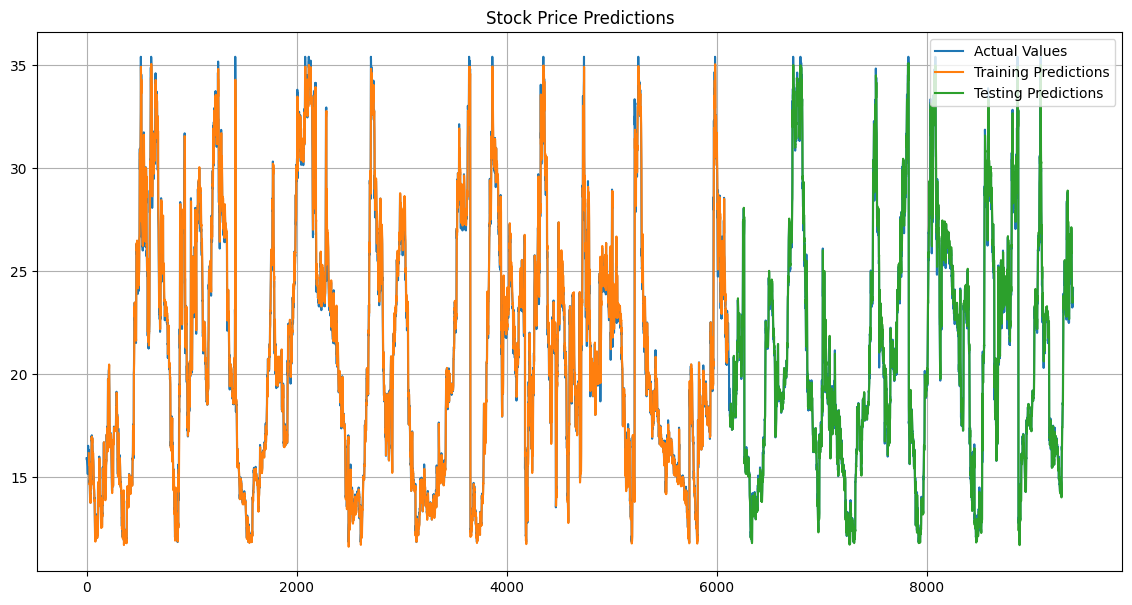

In [18]:

# Plotting
look_back = time_step
trainPredictPlot = np.empty_like(combined_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(combined_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(combined_data) - 1, :] = test_predict

plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(combined_data), label='Actual Values')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Testing Predictions')
plt.legend()
plt.grid(True)
plt.title('Stock Price Predictions')
plt.show()


In [19]:

# Predict the next 10 days
n_steps = 20
x_input = test_data[len(test_data) - n_steps:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
for i in range(10):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())


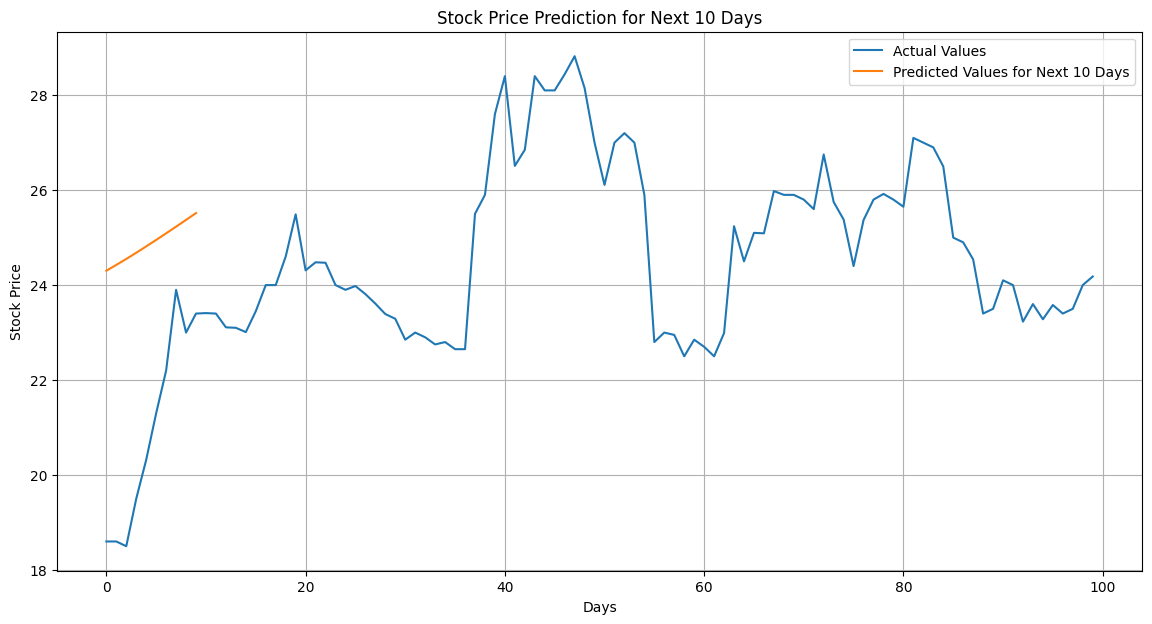

In [20]:

# Plot the last 100 actual values and the predicted values for the next 10 days
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(combined_data[len(combined_data)-100:]), label='Actual Values')
plt.plot(scaler.inverse_transform(lst_output), label='Predicted Values for Next 10 Days')
plt.title('Stock Price Prediction for Next 10 Days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


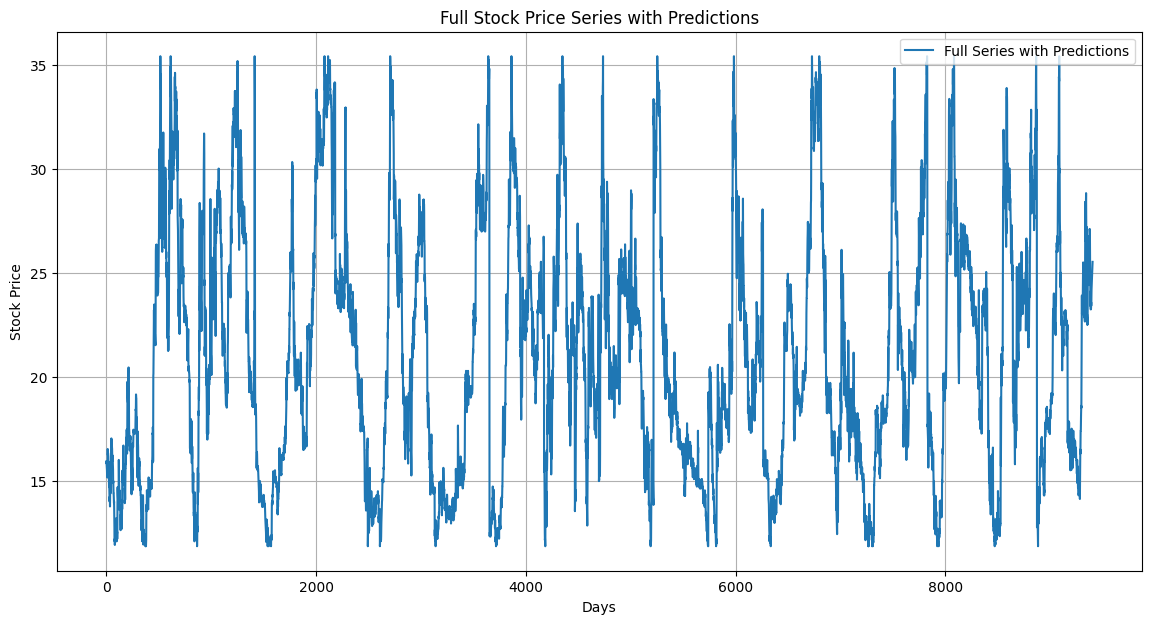

In [21]:

# Full visualization including all data points and predictions
stock_pred = combined_data.tolist()
stock_pred.extend(lst_output)
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(stock_pred), label='Full Series with Predictions')
plt.title('Full Stock Price Series with Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
